<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix

from sklearn.preprocessing import OrdinalEncoder 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

In [2]:
data.columns=data.columns.str.lower() # Определим random_state
ran_st= 12345

## Подготовка данных

In [3]:
df = pd.read_csv('/datasets/Churn.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Признаки** *

 - RowNumber — индекс строки в данных
 - CustomerId — уникальный идентификатор клиента
 - Surname — фамилия
 - CreditScore — кредитный рейтинг
 - Geography — страна проживания
 - Gender — пол
 - Age — возраст
 - Tenure — сколько лет человек является клиентом банка
 - Balance — баланс на счёте
 - NumOfProducts — количество продуктов банка, используемых клиентом
 - HasCrCard — наличие кредитной карты
 - IsActiveMember — активность клиента
 - EstimatedSalary — предполагаемая зарплата
 
**Целевой признак**

 - Exited — факт ухода клиента
 
 
  *Из описания задачи

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [8]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

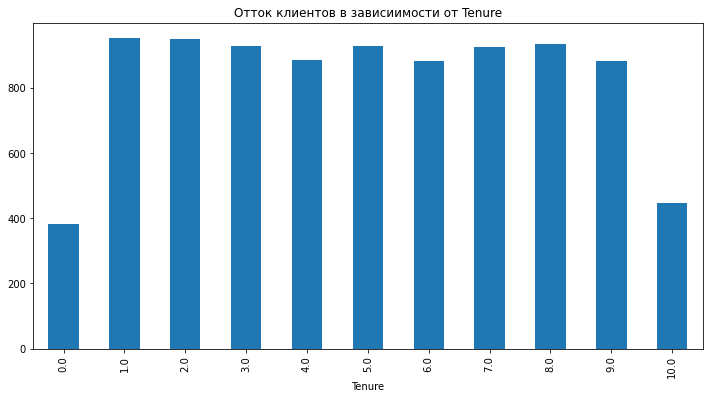

In [9]:
d.fgroupby('Tenure')['Exited'].count().plot(figsize=(12,6),kind='bar',title='Отток клиентов в зависимости от Tenure')
plt.show()

Три варианта решения:

- Удалить объекты с пропущенными значениями, так как их немного (менее 10%) (df.dropna(inplace=True)
- Заменить пропуски на минимальное значение (0) (df['Tenure'] = df['Tenure'].fillna(0))
- Заменить пропуски на медианное значение 

Решение: Заменим нулевыми значениями

In [10]:
#df['Tenure'] = df['Tenure'].fillna(0)
ten_median = df['Tenure'].median()
df['Tenure'] = df['Tenure'].fillna(ten_median)

In [11]:
df['Tenure'].value_counts()

5.0     1836
1.0      952
2.0      950
8.0      933
3.0      928
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: Tenure, dtype: int64

In [12]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Вывод**

 - RowNumber, CustomerId, Surname — столбцы можно удалить, т.к они относятся к идентификационным признакам клиента и не используются в модели ML.
 - CreditScore — следует проверить распределение и сохранить данный столбец.
 - Geography —  выполнить преобразование техникой прямого кодирования (далее - OHE) или ordinal encoding
 - Gender — преобразовать OHE или ordinal encoding.
 - AgeTenure, 	Balance,	NumOfProducts,	HasCrCard,	IsActiveMember,	EstimatedSalary, Exited — оставить в исходном формате.

In [13]:
#Удалим столбцы, которые не будут использованы при построении модели 
drop_col = ['RowNumber','CustomerId', 'Surname']
df = df.drop(drop_col, axis=1)

In [14]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [15]:
df.shape

(10000, 11)

In [16]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Вывод по графику: 
Первоначально построил график со всеми переменными. 
Однако сильной зависимости  между большинством переменных отмечено не было. 

Изначально были предположения, что уход клиентов связан со следующими факторами:
  - плохим обслуживаением на какой-то отдельно взятой территории
  - принадлежность к группе лиц определенного возраста
  - по генедерному признакую,  
  
Изначально былагипотеза, что некоторые ушедшие клиенты хотят дополнительных услуг, например, цифровизации, или которым предлагают "какие-то новомодные фенечки" в других кредитных организациях..
Однако эти предположения не подтверждаются графиками.

Из графиков увидел одну интересную зависимость: уходят, в основном те клиенты, кто пользуется 3-4 продуктами банка. Вероятно, им нужны дополнительные услуги которые Банк не может предложить. Также возможно, что качество предлагаемых услуг не соответствует рыночным характеристикам или сервису. 

In [17]:
# Обработаем данные методом OHE, что позволит нам использовать разные модели и не попасть в дамми ловушку
#df = pd.get_dummies(df, drop_first=True)
#df.head()

##Ordinal Encoder

In [18]:
encoder = OrdinalEncoder()
df = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  float64
 1   Geography        10000 non-null  float64
 2   Gender           10000 non-null  float64
 3   Age              10000 non-null  float64
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  float64
 7   HasCrCard        10000 non-null  float64
 8   IsActiveMember   10000 non-null  float64
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  float64
dtypes: float64(11)
memory usage: 859.5 KB


При прямом кодировании, в новом датафрейме количество столбцов увеличелось на 1. Столбец Geography содержал 3 класса, Gender_Male 2 класса — в результате мы получили только 2 и 1 столбцов соответственно, что позволяет избежать дами-ловушки.

По рекоменндации ревьюера, применили Порядковое кодирование. 

In [20]:
#sns.pairplot(df, hue='Exited') 
#Закомментировал, чтобы не занимать места и время на построение. Оставил только с 
#выборочным количеством переменных

In [21]:
for_pl = ['Age', 'Tenure', 'NumOfProducts', 'Exited']
df_plot = df[for_pl]
#df_plot.head() - для проверки

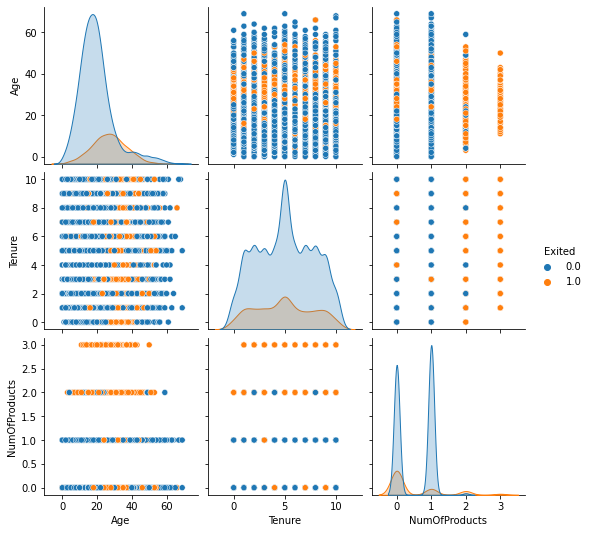

In [22]:
sns.pairplot(df_plot, hue='Exited')

In [23]:
#Разделим данные на признаки и целевой признак
features = df.drop('Exited', axis=1)
target = df['Exited']

Сформируем выборки для моделирования:
 - Обучающая - 60% 
 - Валидационная - 20% 
 - Тестовая - 20%

In [24]:
features_train, features_validtest, target_train, target_validtest = train_test_split(
    features, target, test_size=0.4, stratify=target, random_state=ran_st)

In [25]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_validtest, target_validtest, test_size=0.5, random_state=ran_st)

In [26]:
# Скопировал и подправил из того, что скинул в своём комментарии
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [4778 1222]
Количество строк в target_valid по классам: [1609  391]
Количество строк в target_test по классам: [1576  424]


<div class="alert alert-info">
<font size="4"></font>
    <font size="3", color = "black">
Впрочем, нам сложно сравнивать баланс когда разное количество элементов в выборке, лучше нормализовывать и смотреть именно отношение одного к другому, а не просто количества элементов:

In [27]:
# От ревьюера:
print(f"Количество строк в target_train по классам:\n {target_train.value_counts(normalize=True)}")
print(f"Количество строк в target_valid по классам:\n {target_valid.value_counts(normalize=True)}")
print(f"Количество строк в target_test по классам:\n {target_test.value_counts(normalize=True)}")

Количество строк в target_train по классам:
 0.0    0.796333
1.0    0.203667
Name: Exited, dtype: float64
Количество строк в target_valid по классам:
 0.0    0.8045
1.0    0.1955
Name: Exited, dtype: float64
Количество строк в target_test по классам:
 0.0    0.788
1.0    0.212
Name: Exited, dtype: float64


<div class="alert alert-info">
<font size="4"></font>
    <font size="3", color = "black">
Видно, что расхождения балансов классов не критичные, но есть.

А если бы мы использовали параметр stratify в обоих разбиениях:

In [28]:
# КОД РЕВЬЮЕРА
X_train, X_validtest, y_train, y_validtest = train_test_split(
    features, target, test_size=0.4, stratify=target, random_state=ran_st)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_validtest, y_validtest, test_size=0.5, random_state=ran_st, stratify=y_validtest)

print(f"Количество строк в target_train по классам:\n {y_train.value_counts(normalize=True)}")
print(f"Количество строк в target_valid по классам:\n {y_valid.value_counts(normalize=True)}")
print(f"Количество строк в target_test по классам:\n {y_test.value_counts(normalize=True)}")

Количество строк в target_train по классам:
 0.0    0.796333
1.0    0.203667
Name: Exited, dtype: float64
Количество строк в target_valid по классам:
 0.0    0.796
1.0    0.204
Name: Exited, dtype: float64
Количество строк в target_test по классам:
 0.0    0.7965
1.0    0.2035
Name: Exited, dtype: float64


<div class="alert alert-info">
<font size="4"></font>
    <font size="3", color = "black">
Балансы во всех 3 выборках почти идентичны.
В текущей задаче не слишком критично, но чем сильнее дисбаланс в исходных данных, тем сильнее потенциально опаснее разбивать на выборки без stratify.

In [29]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 10)
(2000, 10)
(2000, 10)


Данные готовы для моделирования

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
баланс выборок ОК

## Исследование задачи

<AxesSubplot:title={'center':'Результирующий признак'}>

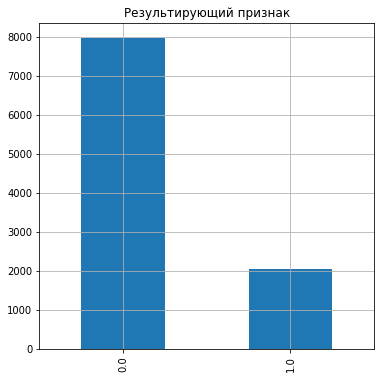

In [30]:
#График оттока и оставшихся клиентов
df['Exited'].value_counts().plot(
    kind='bar', grid=True,figsize=(6,6),title='Результирующий признак')

Соотношение ушедших и оставшихся клиентов составляет 1:4. Это говорит, что присутствует дисбаланс в данных.

In [31]:
df.corr()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,0.008054,-0.002991,-0.003697,-0.000267,0.002516,0.012171,-0.005326,0.025445,-0.001140,-0.026002
Geography,0.008054,1.000000,0.004719,0.022881,-0.000846,0.051726,0.003972,-0.008523,0.006724,-0.001277,0.035943
Gender,-0.002991,0.004719,1.000000,-0.027664,0.012041,0.016055,-0.021859,0.005766,0.022544,-0.008269,-0.106512
Age,-0.003697,0.022881,-0.027664,1.000000,-0.012578,0.019862,-0.030707,-0.011697,0.085408,-0.007334,0.285537
Tenure,-0.000267,-0.000846,0.012041,-0.012578,1.000000,-0.003280,0.011409,0.025979,-0.030681,0.010080,-0.015989
Balance,0.002516,0.051726,0.016055,0.019862,-0.003280,1.000000,-0.238570,-0.005535,-0.013556,0.009749,0.097264
NumOfProducts,0.012171,0.003972,-0.021859,-0.030707,0.011409,-0.238570,1.000000,0.003183,0.009612,0.014248,-0.047820
HasCrCard,-0.005326,-0.008523,0.005766,-0.011697,0.025979,-0.005535,0.003183,1.000000,-0.011866,-0.010042,-0.007138
IsActiveMember,0.025445,0.006724,0.022544,0.085408,-0.030681,-0.013556,0.009612,-0.011866,1.000000,-0.011469,-0.156128
EstimatedSalary,-0.001140,-0.001277,-0.008269,-0.007334,0.010080,0.009749,0.014248,-0.010042,-0.011469,1.000000,0.012081


<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Тут есть нюанс: коэффициенты корреляции Пирсона и Спирмена преподалагют, что признаки численные, а ты вычисляешь корреляции в том числе и для категориальных. Надо понимать, что коэффициенты корреляции Пирсона и Спирмена для категориальных признаков - не самая адекватная оценка из зависимости.

В работе это ничего не ломает, но как факт лучше об этом знать.

Признаки не сильно коррелируются с целевым признаком, поэтому линейные методы прогнозирования не подойдут.

Стандартизируем тестовую и валидную выборку, т.к есть значения неоднородны. 

In [32]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler=StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#scaler.fit(features_train[numeric])
#features_train[numeric] = scaler.transform(features_train[numeric])
#features_valid[numeric] = scaler.transform(features_valid[numeric])
#features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_598/1454025539.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.fit_transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

В результате мы получили масштабированные признаки для выборок. 

Посчитаем accuracy для всех моделей (с учетом понимания, что accuracy не является показателььной мерой, когда наблюдается сильный дисбаланс классов).

In [33]:
# def all_models_accuracy(features_train, target_train, features_valid, target_valid):
#    model_tree = DecisionTreeClassifier(random_state=ran_st)
#    tree_score = model_tree.fit(features_train, target_train).score(features_valid, target_valid)
#    
#    model_forest = RandomForestClassifier(max_depth=7, n_estimators=43, min_samples_leaf=3, random_state=ran_st)
#    forest_score = model_forest.fit(features_train, target_train).score(features_valid, target_valid)
#    
#    model_logistic = LogisticRegression(solver = 'liblinear', random_state=ran_st)
#   logistic_score = model_logistic.fit(features_train, target_train).score(features_valid, target_valid)
#   
#    print("Точность:" "дерево решений - ", tree_score, "случайный лес - ", forest_score, "логистческая регрессия - ", logistic_score)

In [34]:
#all_models_accuracy(features_train, target_train, features_valid, target_valid)

**Обучение моделей и поиск лучших параметров без учета баланса классов выборки**

In [35]:
#Функция для расчета 'fpr,tpr,thresholds'
def fpr_tpr_thresholds(model, features_valid, target_valid):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr,tpr,thresholds=roc_curve(target_valid, probabilities_one_valid)
    return fpr, tpr, thresholds

In [36]:
#Функция для расчета 'ROC-кривой'
def roc_auc(model, features_valid, target_valid):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    return roc_auc
    #print("'ROC-кривая', roc_auc) 

In [37]:
#Функция для расчета полноты, точности и F1-меры
def rec_prec_f1(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))

**Дерево решений без взвешивания классов**

In [38]:
#Дерево решений (без взвешивания классов)
f1_max = 0
depth_max = 0
for depth in range(3,15,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=ran_st).fit(features_train,target_train)
    prediction_tree = model_tree.predict(features_valid)
    f1 = f1_score(target_valid, prediction_tree)
    if f1_max < f1:
        f1_max =  f1
        depth_max = depth

best_model_tree_pure = DecisionTreeClassifier(max_depth=depth_max,random_state=ran_st).fit(features_train,target_train)

f1_tree_pure = f1_max
fpr_tree_pure, tpr_tree_pure, thresholds_tree_pure = fpr_tpr_thresholds(best_model_tree_pure, features_valid, target_valid)
roc_auc_tree_pure = roc_auc(best_model_tree_pure, features_valid, target_valid)

print('max_depth:',depth_max,'F1:',f1_tree_pure)
print('ROC AUC:',roc_auc_tree_pure)

max_depth: 8 F1: 0.5552147239263803
ROC AUC: 0.7668159759918235


<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Было бы неплохо ещё создать глобальную переменную типа best_model и хранить в ней лучшую модель, чтобы потом, на тестировании, не обучать модель заново
        
        Сделал, также и гиперпараметры

**Случайный лес без взвешивания классов**

In [39]:
#Случайный лес (без взвешивания классов)
f1_max = 0
n_estim_max = 0
max_depth_max = 0
for n_estim in range(40,100,1):
    for max_depth in range(3,15,1):
        model_forest=RandomForestClassifier(max_depth=max_depth,n_estimators=n_estim,random_state=ran_st).fit(features_train,target_train)
        prediction_forest = model_forest.predict(features_valid)
        f1 = f1_score(target_valid, prediction_forest)
        if f1_max < f1:
            f1_max =  f1
            n_estim_max = n_estim
            max_depth_max = max_depth

best_model_forest_pure = RandomForestClassifier(
    max_depth=max_depth_max,n_estimators=n_estim_max,random_state=ran_st).fit(features_train,target_train)

fpr_forest_pure, tpr_forest_pure, thresholds_forest_pure = fpr_tpr_thresholds(best_model_forest_pure, features_valid, target_valid)
f1_forest_pure = f1_max
roc_auc_forest_pure = roc_auc(best_model_forest_pure, features_valid, target_valid)

n_estim_final_pure = n_estim_max
max_depth_final_pure = max_depth_max

print('estim',n_estim_max, 'max_depth', max_depth_max, 'F1:',f1_forest_pure)   
print('ROC AUC:',roc_auc_forest_pure)  

estim 80 max_depth 11 F1: 0.564935064935065
ROC AUC: 0.8555805817341393


**Логистическая регрессия без взвешивания классов**

In [40]:
#Логистическая регрессии (без взвешивание классов)
model_logistic=LogisticRegression(solver = 'liblinear', random_state=ran_st).fit(features_train,target_train)
prediction_logistic = model_logistic.predict(features_valid)


f1_log_pure = f1_score(target_valid, prediction_logistic)
fpr_log_pure, tpr_log_pure, thresholds_log_pure = fpr_tpr_thresholds(model_logistic, features_valid, target_valid)
roc_auc_log_pure = roc_auc(model_logistic, features_valid, target_valid)

print('F1:',f1_log_pure)   
print('ROC AUC:',roc_auc_log_pure)

F1: 0.22396856581532418
ROC AUC: 0.7637489886651014


**Вывод:**
Рассматривая заранее преподготовленные данные с дисбалансом с помощью разных моделей,  получили, что саммая лучшая модель оказалась Дерево решения. При значении max_depth=7,  F1 меру составила 0,586 на тестовой(валидной) выборке.

## Борьба с дисбалансом

Три способа борьбы с дисбалансом:
 - Взвешивание классов
 - Увеличение выборки 
 - Уменьшение выборки

**Взвешивание классов (с помощью аргумента class_weight='balanced')**

In [41]:
#Дерево решений (взвешивание классов)
#%%time
f1_max = 0
depth_max = 0
for depth in range(3,15,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=ran_st, class_weight='balanced')
    model_tree.fit(features_train,target_train)
    prediction_tree = model_tree.predict(features_valid)
    f1 = f1_score(target_valid, prediction_tree)
    if f1_max < f1:
        f1_max =  f1
        depth_max = depth
    

best_model_tree_balance = DecisionTreeClassifier(
    max_depth=depth_max,random_state=ran_st, class_weight='balanced').fit(features_train,target_train)

f1_tree_balance = f1_max
fpr_tree_balance, tpr_tree_balance, thresholds_tree_balance = fpr_tpr_thresholds(best_model_tree_balance, features_valid, target_valid)
roc_auc_tree_balance = roc_auc(best_model_tree_balance, features_valid, target_valid)

print('max_depth:',depth_max,'F1:',f1_tree_balance)
print('ROC AUC:',roc_auc_tree_balance)


max_depth: 4 F1: 0.5636172450052577
ROC AUC: 0.8195699064882798


In [42]:
#Случайный лес (взвешивание классов)
#%%time
f1_max = 0
n_estim_max = 0
max_depth_max = 0
for n_estim in range(40,100,1):
    for max_depth in range(3,15,1):
        model_forest=RandomForestClassifier(
            max_depth=max_depth,n_estimators=n_estim,random_state=ran_st, class_weight='balanced').fit(features_train,target_train)
        prediction_forest = model_forest.predict(features_valid)
        f1 = f1_score(target_valid, prediction_forest)
        if f1_max < f1:
            f1_max =  f1
            n_estim_max = n_estim
            max_depth_max = max_depth 

best_model_forest_balance = RandomForestClassifier(
    max_depth=max_depth_max,n_estimators=n_estim_max,random_state=ran_st, class_weight='balanced').fit(features_train,target_train)

fpr_forest_balance, tpr_forest_balance, thresholds_forest_balance = fpr_tpr_thresholds(best_model_forest_balance, features_valid, target_valid)
f1_forest_balance = f1_max
roc_auc_forest_balance = roc_auc(best_model_forest_balance, features_valid, target_valid)

n_estim_final_bal = n_estim_max
max_depth_final_bal = max_depth_max

print('estim',n_estim_max, 'max_depth', max_depth_max, 'F1:',f1_forest_balance)   
print('ROC AUC:',roc_auc_forest_balance)  

estim 65 max_depth 7 F1: 0.6076502732240437
ROC AUC: 0.8564405144336762


In [43]:
#Логистическая регрессии (взвешивание классов)
model_logistic=LogisticRegression(solver = 'liblinear', random_state=ran_st, class_weight='balanced').fit(features_train,target_train)
prediction_logistic = model_logistic.predict(features_valid)

f1_log_balance = f1_score(target_valid, prediction_logistic)
fpr_log_balance, tpr_log_balance, thresholds_log_balance = fpr_tpr_thresholds(model_logistic, features_valid, target_valid)
roc_auc_log_balance = roc_auc(model_logistic, features_valid, target_valid)

print('F1:',f1_log_balance)   
print('ROC AUC:',roc_auc_log_balance)

F1: 0.4847428073234525
ROC AUC: 0.7704424759067839


<Figure size 432x288 with 0 Axes>

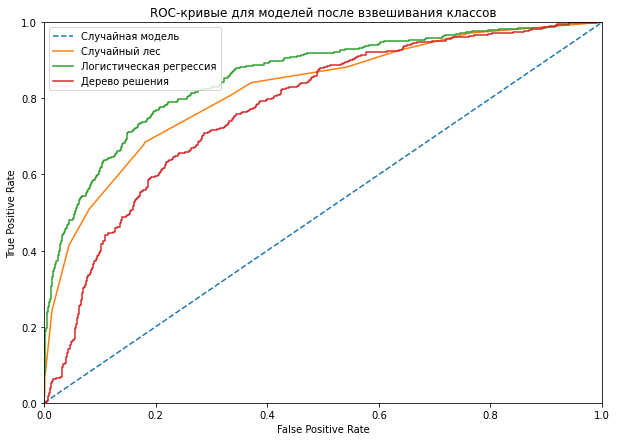

In [44]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_tree_balance,tpr_tree_balance)
plt.plot(fpr_forest_balance,tpr_forest_balance)
plt.plot(fpr_log_balance,tpr_log_balance)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для моделей после взвешивания классов')
plt.legend(('Случайная модель','Случайный лес','Логистическая регрессия','Дерево решения'), loc= 'upper left') 
plt.show()

**С помощью функции Upsampling (увеличим количество клиентов, ушедших из Банка Exited = 1)**

In [45]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=ran_st)
    
    return features_upsampled, target_upsampled

In [46]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [47]:
#Дерево решений (Upsampling)
#%%time
f1_max = 0
depth_max = 0
for depth in range(3,15,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=ran_st)
    model_tree.fit(features_upsampled, target_upsampled)
    prediction_tree = model_tree.predict(features_valid)
    f1 = f1_score(target_valid, prediction_tree)
    if f1_max < f1:
        f1_max =  f1
        depth_max = depth
    

best_model_tree_up = DecisionTreeClassifier(
    max_depth=depth_max,random_state=ran_st).fit(features_upsampled, target_upsampled)

f1_tree_up = f1_max
fpr_tree_up, tpr_tree_up, thresholds_tree_up = fpr_tpr_thresholds(best_model_tree_up, features_valid, target_valid)
roc_auc_tree_up = roc_auc(best_model_tree_up, features_valid, target_valid)

print('max_depth:',depth_max,'F1:',f1_tree_up)
print('ROC AUC:',roc_auc_tree_up)

max_depth: 4 F1: 0.5636172450052577
ROC AUC: 0.8195699064882798


In [48]:
#Случайный лес (Upsampling)
#%%time
f1_max = 0
n_estim_max = 0
max_depth_max = 0
for n_estim in range(40,100,1):
    for max_depth in range(3,15,1):
        model_forest=RandomForestClassifier(max_depth=max_depth,n_estimators=n_estim,random_state=ran_st)
        model_forest.fit(features_upsampled, target_upsampled)
        prediction_forest = model_forest.predict(features_valid)
        f1 = f1_score(target_valid, prediction_forest)
        if f1_max < f1:
            f1_max =  f1
            n_estim_max = n_estim
            max_depth_max = max_depth 
            
            
best_model_forest_up = RandomForestClassifier(
    max_depth=max_depth_max,n_estimators=n_estim_max,random_state=ran_st).fit(features_upsampled, target_upsampled) 

fpr_forest_up, tpr_forest_up, thresholds_forest_up = fpr_tpr_thresholds(best_model_forest_up, features_valid, target_valid)
f1_forest_up = f1_max
roc_auc_forest_up = roc_auc(best_model_forest_up, features_valid, target_valid)

n_estim_final_up = n_estim_max
max_depth_final_up = max_depth_max

print('estim',n_estim_max, 'max_depth', max_depth_max, 'F1:',f1_forest_up)   
print('ROC AUC:',roc_auc_forest_up)  

estim 74 max_depth 9 F1: 0.6114101184068892
ROC AUC: 0.851071101015865


In [49]:
#Логистическая регрессия (Upsampling)
model_logistic = LogisticRegression(random_state=ran_st,solver='liblinear')
model_logistic.fit(features_upsampled, target_upsampled)
prediction_logistic = model_logistic.predict(features_valid)

f1_log_up = f1_score(target_valid, prediction_logistic)
fpr_log_up, tpr_log_up, thresholds_log_up = fpr_tpr_thresholds(model_logistic, features_valid, target_valid)
roc_auc_log_up = roc_auc(model_logistic, features_valid, target_valid)

print('F1:',f1_log_up)   
print('ROC AUC:',roc_auc_log_up)

F1: 0.48068669527896996
ROC AUC: 0.7704218120896046


<Figure size 432x288 with 0 Axes>

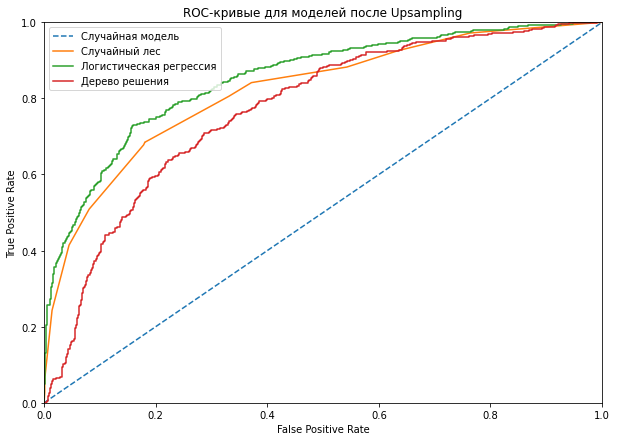

In [50]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_tree_up,tpr_tree_up)
plt.plot(fpr_forest_up,tpr_forest_up)
plt.plot(fpr_log_up,tpr_log_up)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для моделей после Upsampling')
plt.legend(('Случайная модель','Случайный лес','Логистическая регрессия','Дерево решения'), loc= 'upper left') 
plt.show()

**С помощью функции Downsampling (уменьшим количество клиентов, не ушедших из Банка Exited = 0)**

In [51]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=ran_st)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=ran_st)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=ran_st)
    
    return features_downsampled, target_downsampled


In [52]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [53]:
#Дерево решений (Downsampling)
#%%time
f1_max = 0
depth_max = 0
for depth in range(3,15,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=ran_st)
    model_tree.fit(features_downsampled, target_downsampled)
    prediction_tree = model_tree.predict(features_valid)
    f1 = f1_score(target_valid, prediction_tree)
    if f1_max < f1:
        f1_max =  f1
        depth_max = depth   

best_model_tree_down = DecisionTreeClassifier(max_depth=depth_max,random_state=ran_st).fit(features_downsampled, target_downsampled)

f1_tree_down = f1_max
fpr_tree_down, tpr_tree_down, thresholds_tree_down = fpr_tpr_thresholds(best_model_tree_down, features_valid, target_valid)
roc_auc_tree_down = roc_auc(best_model_tree_down, features_valid, target_valid)

print('max_depth:',depth_max,'F1:',f1_tree_down)
print('ROC AUC:',roc_auc_tree_down)

max_depth: 4 F1: 0.5623678646934461
ROC AUC: 0.819049337247802


In [54]:
#Случайный лес (Downsampling)
#%%time
f1_max = 0
n_estim_max = 0
max_depth_max = 0
for n_estim in range(40,100,1):
    for max_depth in range(3,15,1):
        model_forest=RandomForestClassifier(max_depth=max_depth,n_estimators=n_estim,random_state=ran_st).fit(features_downsampled, target_downsampled)
        prediction_forest = model_forest.predict(features_valid)
        f1 = f1_score(target_valid, prediction_forest)
        if f1_max < f1:
            f1_max =  f1
            n_estim_max = n_estim
            max_depth_max = max_depth   

best_model_forest_down = RandomForestClassifier(
    max_depth=max_depth_max,n_estimators=n_estim_max,random_state=ran_st).fit(features_downsampled, target_downsampled)

fpr_forest_down, tpr_forest_down, thresholds_forest_down = fpr_tpr_thresholds(best_model_forest_down, features_valid, target_valid)
f1_forest_down = f1_max
roc_auc_forest_down = roc_auc(best_model_forest_down, features_valid, target_valid)

n_estim_final_down = n_estim_max
max_depth_final_down = max_depth_max

print('estim',n_estim_max, 'max_depth', max_depth_max, 'F1:',f1_forest_down)   
print('ROC AUC:',roc_auc_forest_down)  

estim 72 max_depth 5 F1: 0.5931034482758621
ROC AUC: 0.8494402489831018


In [55]:
#Логистическая регрессия (Downsampling)
model_logistic = LogisticRegression(random_state=ran_st,solver='liblinear').fit(features_downsampled, target_downsampled)
prediction_logistic = model_logistic.predict(features_valid)

f1_log_down = f1_score(target_valid, prediction_logistic)
fpr_log_down, tpr_log_down, thresholds_log_down = fpr_tpr_thresholds(model_logistic, features_valid, target_valid)
roc_auc_log_down = roc_auc(model_logistic, features_valid, target_valid)

print('F1:',f1_log_down)   
print('ROC AUC:',roc_auc_log_down)

F1: 0.48578811369509045
ROC AUC: 0.7686574400073753


<Figure size 432x288 with 0 Axes>

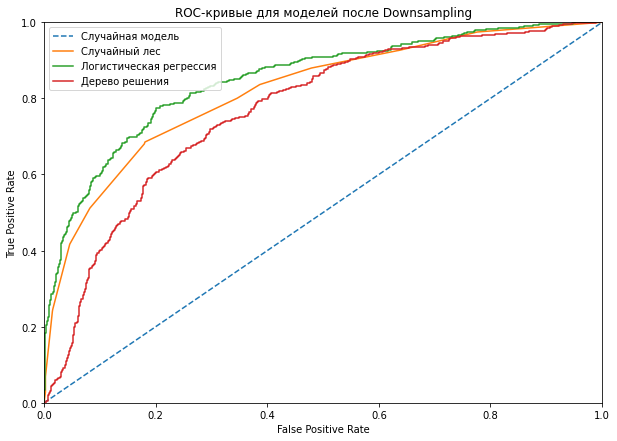

In [56]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_tree_down,tpr_tree_down)
plt.plot(fpr_forest_down,tpr_forest_down)
plt.plot(fpr_log_down,tpr_log_down)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для моделей после Downsampling')
plt.legend(('Случайная модель','Случайный лес','Логистическая регрессия','Дерево решения'), loc= 'upper left') 
plt.show()

Вывод: Самая лучшая модель оказалась модель Случайный лес со взвешенными классами.

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
В целом по борьбе с дисбалансом всё весьма неплохо, одобряю

## Тестирование модели

In [57]:
#Обучим финальную модель
#Случайный лес (Upsampling)
model_final=RandomForestClassifier(max_depth=max_depth_final_up,n_estimators=n_estim_final_up,random_state=ran_st)
model_final.fit(features_upsampled, target_upsampled)
model_final_prediction = model_final.predict(features_test)
rec_prec_f1(target_test, model_final_prediction)
model_final_valid = model_final.predict_proba(features_test)[:, 1]

Полнота 0.7193396226415094
Точность 0.5669144981412639
F1-мера 0.6340956340956341


<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Хорошая метрика!
<br />

In [65]:
#Обучим финальную модель
#Случайный лес (Balanced)
#model_final=RandomForestClassifier(max_depth=max_depth_final_bal,n_estimators=n_estim_final_bal,random_state=ran_st, class_weight='balanced')
#model_final.fit(features_train,target_train)
#model_final_prediction = model_final.predict(features_test)
#rec_prec_f1(target_test, model_final_prediction)
#model_final_valid = model_final.predict_proba(features_test)[:, 1]

In [66]:
#Создаем константную модель
target_predict_constant = pd.Series([0]*len(target_test))
target_predict_constant.value_counts()

0    2000
dtype: int64

In [67]:
#Сравним показатель точности (accuracy_score) константной модели и финальной
print('accuracy_score константой модели:', accuracy_score(target_valid, target_predict_constant))
print('accuracy_score финальной модели:', accuracy_score(target_test, model_final_prediction))
#Дополнительно сравним AUC-ROC — единственный параметр подающийся сравнению, потому что константная подель содержит только негативные ответы
print('AUC-ROC константой модели:', roc_auc_score(target_valid, target_predict_constant))
print('AUC-ROC финальной модели:', roc_auc_score(target_test, model_final_valid))

accuracy_score константой модели: 0.8045
accuracy_score финальной модели: 0.672
AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.8650317857484915


In [68]:
roc_auc_final = roc_auc(model_final, features_valid, target_valid)
fpr_final,tpr_final,thresholds_final = fpr_tpr_thresholds(model_final, features_valid, target_valid)

<Figure size 432x288 with 0 Axes>

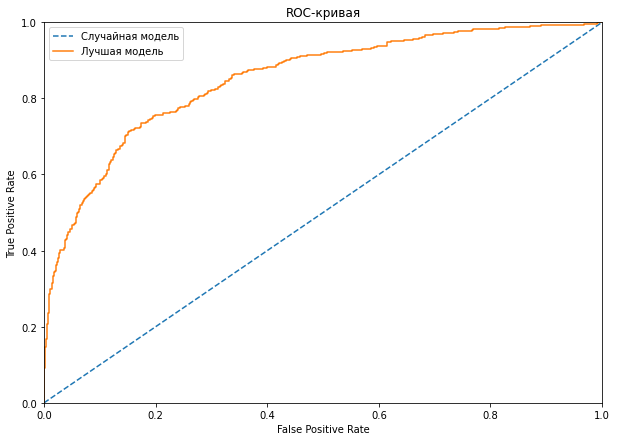

In [69]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_final, tpr_final)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Лучшая модель'), loc= 'upper left') 
plt.show()

In [70]:
tree_array = [f1_tree_pure, f1_tree_balance, f1_tree_up, f1_tree_down]
forest_array = [f1_forest_pure, f1_forest_balance, f1_forest_up, f1_forest_down]
log_array = [f1_log_pure, f1_log_balance, f1_log_up, f1_log_down]
rezult={'Дерево Решения':np.array(tree_array),'Случайный лес':np.array(forest_array),'Логистическая регрессия':np.array(log_array)}
rezult_df=pd.DataFrame(rezult,index=['F1 до балансировки','F1 после балансировки', 'F1 после Upsampling', 'F1 после Downsampling'])


**Общий вывод:**

In [71]:
rezult_df

,Дерево Решения,Случайный лес,Логистическая регрессия
F1 до балансировки,0.555215,0.564935,0.223969
F1 после балансировки,0.563617,0.607650,0.484743
F1 после Upsampling,0.563617,0.611410,0.480687
F1 после Downsampling,0.562368,0.593103,0.485788


В первоначальные данных наблюдался значительный дисбаланс, из-за чего обученная на этих данных модель не проходила проверку на адекватность. Все модели не первоначальных данных характеризовались высокой степенью ошибок и низким качеством F1.
  
Для Разобрали несколько вариантов борьбы с дисбалансом upsampling и downsampling.

При замене пропущенных значений Tenure на "0", самая лучшая модель оказалась модель "Случайный лес" со взвешенными классами.

                        Дерево Решения	Случайный лес	Логистическая регрессия
     F1 до балансировки	    0.554140	0.583468	0.227006
     F1 после балансировки	0.563617	0.615730	0.479863
     F1 после Upsampling	0.563617	0.611289	0.476351
     F1 после Downsampling	0.564211	0.599609	0.483404



 - Полнота 0.7122641509433962
 - Точность 0.568738229755179
 - F1-мера 0.6324607329842932
 
 
 Исследованs метрики *AUC-ROC* и *accuracy*
 - accuracy_score константой модели: 0.8045
 - accuracy_score финальной модели: 0.8245
 - AUC-ROC константой модели: 0.5
 - AUC-ROC финальной модели: 0.8647923450818888


При замене пропущенных значений Tenure на "медиану", самая лучшая модель оказалась модель "Случайный лес" Upsampling.

 - Полнота 0.7193396226415094
 - Точность 0.5669144981412639
 - F1-мера 0.6340956340956341

 Исследованs метрики *AUC-ROC* и *accuracy*
 - accuracy_score константой модели: 0.8045
 - accuracy_score финальной модели: 0.824
 - AUC-ROC константой модели: 0.5
 - AUC-ROC финальной модели: 0.8695183052389618
 

 
В дополнение: Уходят, в основном те, кто пользуется 3-4 продуктами банка. Вероятно, им нужны дополнительные услуги которые Банк не может предложить. Также возможно, что качество предлагаемых услуг не соответствует рыночным характеристикам или сервису. 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*